In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from ipywidgets import interact, fixed
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import math 

#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from matplotlib.animation import FFMpegWriter
pd.set_option('max_columns', 100)

import dateutil
from math import radians
from IPython.display import Video

import warnings
warnings.filterwarnings('ignore')
#os.chdir('/Users/Richard/Downloads')
#os.getcwd()

File descriptions
Game data: The games.csv contains the teams playing in each game. The key variable is gameId.

Player data: The players.csv file contains player-level information from players that participated in any of the tracking data files. The key variable is nflId.

Play data: The plays.csv file contains play-level information from each game. The key variables are gameId and playId.

Tracking data: Files week[week].csv contain player tracking data from all games in week [week]. The key variables are gameId, playId, and nflId. There are 17 weeks to a typical NFL Regular Season, and thus 17 data frames with player tracking data are provided.

Game data
gameId: Game identifier, unique (numeric)

gameDate: Game Date (time, mm/dd/yyyy)

gameTimeEastern: Start time of game (time, HH:MM:SS, EST)

homeTeamAbbr: Home team three-letter code (text)

visitorTeamAbbr: Visiting team three-letter code (text)

week: Week of game (numeric)

Player data
nflId: Player identification number, unique across players (numeric)

height: Player height (text)

weight: Player weight (numeric)

birthDate: Date of birth (YYYY-MM-DD)

collegeName: Player college (text)

position: Player position (text)

displayName: Player name (text)

Play data
gameId: Game identifier, unique (numeric)

playId: Play identifier, not unique across games (numeric)

playDescription: Description of play (text)

quarter: Game quarter (numeric)

down: Down (numeric)

yardsToGo: Distance needed for a first down (numeric)

possessionTeam: Team on offense (text)

playType: Outcome of dropback: sack or pass (text)

yardlineSide: 3-letter team code corresponding to line-of-scrimmage (text)

yardlineNumber: Yard line at line-of-scrimmage (numeric)

offenseFormation: Formation used by possession team (text)

personnelO: Personnel used by offensive team (text)

defendersInTheBox: Number of defenders in close proximity to line-of-scrimmage (numeric)

numberOfPassRushers: Number of pass rushers (numeric)

personnelD: Personnel used by defensive team (text)

typeDropback: Dropback categorization of quarterback (text)

preSnapHomeScore: Home score prior to the play (numeric)

preSnapVisitorScore: Visiting team score prior to the play (numeric)

gameClock: Time on clock of play (MM:SS)

absoluteYardlineNumber: Distance from end zone for possession team (numeric)

penaltyCodes: NFL categorization of the penalties that ocurred on the play. For purposes of this contest, the most important penalties are Defensive Pass Interference (DPI), Offensive Pass Interference (OPI), Illegal Contact (ICT), and Defensive Holding (DH). Multiple penalties on a play are separated by a ; (text)

penaltyJerseyNumber: Jersey number and team code of the player commiting each penalty. Multiple penalties on a play are separated by a ; (text)

passResult: Outcome of the passing play (C: Complete pass, I: Incomplete pass, S: Quarterback sack, IN: Intercepted pass, text)

offensePlayResult: Yards gained by the offense, excluding penalty yardage (numeric)

playResult: Net yards gained by the offense, including penalty yardage (numeric)

epa: Expected points added on the play, relative to the offensive team. Expected points is a metric that estimates the average of every next scoring outcome given the play's down, distance, yardline, and time remaining (numeric)

isDefensivePI: An indicator variable for whether or not a DPI penalty ocurred on a given play (TRUE/FALSE)

Tracking data
Each of the 17 week[week].csv files contain player tracking data from all passing plays during Week [week] of the 2018 regular season. Nearly all plays from each [gameId] are included; certain plays or games with insufficient data are dropped. Each team and player plays no more than 1 game in a given week.

time: Time stamp of play (time, yyyy-mm-dd, hh:mm:ss)

x: Player position along the long axis of the field, 0 - 120 yards. See Figure 1 below. (numeric)

y: Player position along the short axis of the field, 0 - 53.3 yards. See Figure 1 below. (numeric)

s: Speed in yards/second (numeric)

a: Acceleration in yards/second^2 (numeric)

dis: Distance traveled from prior time point, in yards (numeric)

o: Player orientation (deg), 0 - 360 degrees (numeric)

dir: Angle of player motion (deg), 0 - 360 degrees (numeric)

event: Tagged play details, including moment of ball snap, pass release, pass catch, tackle, etc (text)

nflId: Player identification number, unique across players (numeric)

displayName: Player name (text)

jerseyNumber: Jersey number of player (numeric)

position: Player position group (text)

team: Team (away or home) of corresponding player (text)

frameId: Frame identifier for each play, starting at 1 (numeric)

gameId: Game identifier, unique (numeric)

playId: Play identifier, not unique across games (numeric)

playDirection: Direction that the offense is moving (text, left or right)

route: Route ran by offensive player (text)

In [35]:
#game_weeks = ['week1','week7','week14']
game_weeks = ['week1']

#PATH = '/Users/richardolekanma/Downloads/nfl-big-data-bowl-2021/'
PATH = '/Users/richardolekanma/Downloads/nfl-big-data-bowl-2021/week'

week = pd.DataFrame()
#for i in game_weeks:
for i in range(1,18):
    df = pd.read_csv(PATH + str(i) +'.csv')
    #df = pd.read_csv(PATH + i +'.csv')
    week = week.append(df)
week.head()

time      x      y     s     a   dis       o     dir  \
0  2018-09-07T01:07:14.599Z  91.73  26.67  0.00  0.01  0.02  289.57  240.93   
1  2018-09-07T01:07:14.599Z  88.89  36.47  0.01  0.01  0.01  105.63   66.66   
2  2018-09-07T01:07:14.599Z  91.35  44.16  0.02  0.03  0.01  290.45   16.86   
3  2018-09-07T01:07:14.599Z  86.31  22.01  0.09  0.42  0.01   70.12  168.91   
4  2018-09-07T01:07:14.599Z  90.78  36.15  0.00  0.00  0.00  257.61  193.97   

  event      nflId      displayName  jerseyNumber position  frameId  team  \
0  None      310.0        Matt Ryan           2.0       QB        1  away   
1  None    79848.0  Malcolm Jenkins          27.0       SS        1  home   
2  None  2495454.0      Julio Jones          11.0       WR        1  away   
3  None  2495613.0     Corey Graham          24.0       FS        1  home   
4  None  2533040.0     Mohamed Sanu          12.0       WR        1  away   

       gameId  playId playDirection  route  
0  2018090600      75          left    NaN  
1  2018090600      75          left    NaN  
2  2018090600      75          left  HITCH  
3  2018090600      75          left    NaN  
4  2018090600      75          left  HITCH

### Start here if all 17 weeks have already been loaded

In [36]:
#week.to_csv ('/Users/richardolekanma/Downloads/nfl-big-data-bowl-2021/All17Weeks.csv', index = False, header=True)


In [6]:
week = pd.read_csv('/Users/richardolekanma/Downloads/nfl-big-data-bowl-2021/All17Weeks.csv')
week.head()

time      x      y     s     a   dis       o     dir  \
0  2018-09-07T01:07:14.599Z  91.73  26.67  0.00  0.01  0.02  289.57  240.93   
1  2018-09-07T01:07:14.599Z  88.89  36.47  0.01  0.01  0.01  105.63   66.66   
2  2018-09-07T01:07:14.599Z  91.35  44.16  0.02  0.03  0.01  290.45   16.86   
3  2018-09-07T01:07:14.599Z  86.31  22.01  0.09  0.42  0.01   70.12  168.91   
4  2018-09-07T01:07:14.599Z  90.78  36.15  0.00  0.00  0.00  257.61  193.97   

  event      nflId      displayName  jerseyNumber position  frameId  team  \
0  None      310.0        Matt Ryan           2.0       QB        1  away   
1  None    79848.0  Malcolm Jenkins          27.0       SS        1  home   
2  None  2495454.0      Julio Jones          11.0       WR        1  away   
3  None  2495613.0     Corey Graham          24.0       FS        1  home   
4  None  2533040.0     Mohamed Sanu          12.0       WR        1  away   

       gameId  playId playDirection  route  
0  2018090600      75          left    NaN  
1  2018090600      75          left    NaN  
2  2018090600      75          left  HITCH  
3  2018090600      75          left    NaN  
4  2018090600      75          left  HITCH

In [7]:
week.event.unique()

array(['None', 'ball_snap', 'pass_forward', 'pass_arrived',
       'pass_outcome_caught', 'out_of_bounds', 'pass_outcome_incomplete',
       'first_contact', 'tackle', 'man_in_motion', 'play_action',
       'qb_sack', 'fumble', 'fumble_offense_recovered', 'handoff',
       'pass_tipped', 'pass_outcome_interception', 'qb_strip_sack',
       'pass_shovel', 'line_set', 'shift', 'touchdown',
       'fumble_defense_recovered', 'pass_outcome_touchdown', 'run',
       'touchback', 'penalty_flag', 'penalty_accepted', 'qb_spike',
       'field_goal_blocked', 'punt_fake', 'snap_direct',
       'run_pass_option', 'pass_lateral', 'lateral', 'field_goal_fake',
       'huddle_start_offense', 'huddle_break_offense', 'timeout_home',
       'safety', 'field_goal_play'], dtype=object)

In [8]:
week.position.unique()

array(['QB', 'SS', 'WR', 'FS', 'RB', 'MLB', 'CB', 'TE', 'LB', 'FB', nan,
       'OLB', 'HB', 'ILB', 'DL', 'DB', 'NT', 'S', 'DE', 'P', 'LS', 'K',
       'DT'], dtype=object)

In [9]:
exp = week[80000:85000]
def targetedPlayer(data):
    lst = []
    for game in data.gameId.unique():
        print(game)
        for play in data.query('gameId == @game').playId.unique():
            print(play)
            football_df = data.query('gameId == @game and displayName == "Football" and playId == @play and event == "pass_arrived"')
            f_x = football_df.x.values
            f_y = football_df.y.values
            print(f'Where the football is: {f_x, f_y}')
            if len(f_x) == 0:
                pass
            elif len(f_x) > 1:
                f_x = football_df.x.values[1]
                f_y = football_df.y.values[1]
            else:
                for row in data.query('gameId == @game and playId == @play and event == "pass_arrived"').itertuples(index = False):

                    d_x = abs(row[1])
                    d_y = abs(row[2])
                    d_name = row[10]
                    d_pos = row[12]
                    d_event = row[8]
                    print(f'distance from ball {d_x, d_y}')
                    dist = math.sqrt((d_x-f_x)**2+(d_y-f_y)**2)
                    #print(f'distance from ball {dist}')
                    lst.append([game,play,d_name,d_pos, dist])
    #data = data.query('event == "pass_arrived"')
    #data['distance_from_ball'] = lst
    df = pd.DataFrame(lst, columns = ['gameId','playId','displayName','position','distance_from_ball']) 

    return df

targeted = targetedPlayer(week) 
targeted.head()


2018090600
75
Where the football is: (array([83.29]), array([46.47]))
distance from ball (96.3, 27.52)
distance from ball (82.34, 45.18)
distance from ball (81.11, 47.87)
distance from ball (82.9, 17.62)
distance from ball (77.66, 35.52)
distance from ball (70.28, 35.09)
distance from ball (91.13, 30.53)
distance from ball (82.76, 36.69)
distance from ball (77.11, 17.3)
distance from ball (74.4, 47.11)
distance from ball (78.35, 16.74)
distance from ball (79.94, 31.07)
distance from ball (87.13, 10.93)
distance from ball (83.29, 46.47)
146
Where the football is: (array([45.31]), array([36.39]))
distance from ball (53.9, 29.9)
distance from ball (45.08, 43.86)
distance from ball (33.51, 31.59)
distance from ball (55.99, 24.73)
distance from ball (44.24, 34.98)
distance from ball (44.93, 29.5)
distance from ball (37.4, 9.64)
distance from ball (43.3, 37.96)
distance from ball (46.05, 45.19)
distance from ball (42.35, 27.61)
distance from ball (40.86, 9.44)
distance from ball (45.65, 25.6

gameId  playId      displayName position  distance_from_ball
0  2018090600      75        Matt Ryan       QB           22.986139
1  2018090600      75  Malcolm Jenkins       SS            1.602061
2  2018090600      75      Julio Jones       WR            2.590830
3  2018090600      75     Corey Graham       FS           28.852636
4  2018090600      75     Mohamed Sanu       WR           12.312571

In [24]:
defense = ['SS','FS', 'MLB', 'CB', 'LB', 'OLB', 'ILB','DB', 'S']

for game in targeted.gameId.unique():
    print(game)
    for play in targeted.query('gameId == @game').playId.unique():
        print(play)
        #df.loc[~df.index.isin(t)]
        name = targeted.loc[(targeted['displayName'] != "Football") & (targeted['gameId'] == game) & (targeted['playId'] == play) & (~targeted.position.isin(defense))].nsmallest(1, 'distance_from_ball').displayName.values

        #name = targeted.query('displayName != "Football" and gameId == @game and playId == @play').nsmallest(1, 'distance_from_ball').displayName.values
        newname = name[0]
        
        #targeted.query('gameId == @game and playId == @play and displayName == @name')
        targeted.loc[(targeted['gameId']== game) & (targeted['playId']== play) & (targeted['displayName']== newname), 'targeted'] = 'Yes'


2018090600
75
146
190
256
320
402
492
521
752
949
992
1037
1061
1085
1202
1226
1295
1344
1423
1473
1680
1715
1750
1779
1869
1894
1916
1940
2116
2260
2305
2360
2382
2450
2474
2575
2624
2648
2693
2736
2811
2980
3004
3066
3095
3203
3257
3279
3392
3481
3507
3626
3678
3791
3844
3904
3928
3950
3979
4142
4166
4258
4282
4325
4472
2018090906
58
87
142
284
354
456
480
534
604
628
752
776
868
922
967
1027
1113
1221
1326
1419
1441
1465
1493
1583
1649
1799
1823
1851
1927
1949
2020
2061
2261
2310
2339
2409
2607
2648
2812
2868
2897
2923
2981
3051
3143
3167
3195
3223
3311
3335
3466
3546
3570
3594
3708
3732
3754
3776
3834
3967
4116
4140
4173
4201
4229
2018090907
79
170
192
248
270
498
541
584
641
686
710
936
960
1005
1050
1079
1155
1177
1235
1268
1292
1316
1358
1382
1465
1537
1638
1785
1988
2096
2200
2224
2396
2418
2463
2618
2664
2744
2787
2853
2895
2957
3033
3077
3122
3193
3332
3430
3522
3567
3692
3755
3777
3826
3871
3895
3955
3977
2018090903
79
149
194
218
333
382
424
451
513
596
641
663
685
762
791


IndexError: index 0 is out of bounds for axis 0 with size 0

In [25]:
targeted.head()

gameId  playId      displayName position  distance_from_ball targeted
0  2018090600      75        Matt Ryan       QB           22.986139      NaN
1  2018090600      75  Malcolm Jenkins       SS            1.602061      NaN
2  2018090600      75      Julio Jones       WR            2.590830      Yes
3  2018090600      75     Corey Graham       FS           28.852636      NaN
4  2018090600      75     Mohamed Sanu       WR           12.312571      NaN

In [34]:
week['target'] = 'Not Targeted'
def finishTarget():
    x = targeted.loc[targeted['targeted']=='Yes']
    for row in x.itertuples(index = False):
        playername = row[2]
        playerplay = row[1]
        playergame = row[0]
        week.loc[(week['gameId']== playergame) & (week['playId']== playerplay) & (week['displayName']== playername), 'target'] = 'Targeted'
    print('Done')
    return

finishTarget()

Done


In [36]:
week.head(20)

time      x      y     s     a   dis       o     dir  \
0   2018-09-07T01:07:14.599Z  91.73  26.67  0.00  0.01  0.02  289.57  240.93   
1   2018-09-07T01:07:14.599Z  88.89  36.47  0.01  0.01  0.01  105.63   66.66   
2   2018-09-07T01:07:14.599Z  91.35  44.16  0.02  0.03  0.01  290.45   16.86   
3   2018-09-07T01:07:14.599Z  86.31  22.01  0.09  0.42  0.01   70.12  168.91   
4   2018-09-07T01:07:14.599Z  90.78  36.15  0.00  0.00  0.00  257.61  193.97   
5   2018-09-07T01:07:14.599Z  73.64  28.70  0.03  0.02  0.01  103.05  219.41   
6   2018-09-07T01:07:14.599Z  98.25  26.63  0.01  0.01  0.00  265.88  194.51   
7   2018-09-07T01:07:14.599Z  86.48  31.12  0.09  0.03  0.04   95.90   33.36   
8   2018-09-07T01:07:14.599Z  82.67  20.53  0.03  0.07  0.01   81.14  174.57   
9   2018-09-07T01:07:14.599Z  84.00  43.49  0.14  0.05  0.01  108.23  110.32   
10  2018-09-07T01:07:14.599Z  91.29  21.83  0.01  0.02  0.01  250.34  151.83   
11  2018-09-07T01:07:14.599Z  85.63  26.59  0.03  0.04  0.02   87.69   38.80   
12  2018-09-07T01:07:14.599Z  95.13  26.71  0.01  0.01  0.01  250.10  237.27   
13  2018-09-07T01:07:14.599Z  90.11  26.85  0.00  0.00  0.00     NaN     NaN   
14  2018-09-07T01:07:14.700Z  91.73  26.67  0.00  0.00  0.00  289.57  239.89   
15  2018-09-07T01:07:14.700Z  88.89  36.47  0.01  0.01  0.00  105.63   68.49   
16  2018-09-07T01:07:14.700Z  91.37  44.17  0.03  0.03  0.02  290.45   29.61   
17  2018-09-07T01:07:14.700Z  86.32  22.00  0.10  0.58  0.01   70.88  119.04   
18  2018-09-07T01:07:14.700Z  90.78  36.15  0.00  0.00  0.00  257.61  190.84   
19  2018-09-07T01:07:14.700Z  73.64  28.70  0.03  0.02  0.01  104.57  228.17   

   event      nflId      displayName  jerseyNumber position  frameId  \
0   None      310.0        Matt Ryan           2.0       QB        1   
1   None    79848.0  Malcolm Jenkins          27.0       SS        1   
2   None  2495454.0      Julio Jones          11.0       WR        1   
3   None  2495613.0     Corey Graham          24.0       FS        1   
4   None  2533040.0     Mohamed Sanu          12.0       WR        1   
5   None  2534832.0    Rodney McLeod          23.0       FS        1   
6   None  2543583.0  Devonta Freeman          24.0       RB        1   
7   None  2552315.0     Jordan Hicks          58.0      MLB        1   
8   None  2552689.0     Ronald Darby          21.0       CB        1   
9   None  2555383.0      Jalen Mills          31.0       CB        1   
10  None  2555415.0    Austin Hooper          81.0       TE        1   
11  None  2558175.0       Nate Gerry          47.0       LB        1   
12  None  2559033.0      Ricky Ortiz          30.0       FB        1   
13  None        NaN         Football           NaN      NaN        1   
14  None      310.0        Matt Ryan           2.0       QB        2   
15  None    79848.0  Malcolm Jenkins          27.0       SS        2   
16  None  2495454.0      Julio Jones          11.0       WR        2   
17  None  2495613.0     Corey Graham          24.0       FS        2   
18  None  2533040.0     Mohamed Sanu          12.0       WR        2   
19  None  2534832.0    Rodney McLeod          23.0       FS        2   

        team      gameId  playId playDirection  route        target  
0       away  2018090600      75          left    NaN  Not Targeted  
1       home  2018090600      75          left    NaN  Not Targeted  
2       away  2018090600      75          left  HITCH      Targeted  
3       home  2018090600      75          left    NaN  Not Targeted  
4       away  2018090600      75          left  HITCH  Not Targeted  
5       home  2018090600      75          left    NaN  Not Targeted  
6       away  2018090600      75          left    NaN  Not Targeted  
7       home  2018090600      75          left    NaN  Not Targeted  
8       home  2018090600      75          left    NaN  Not Targeted  
9       home  2018090600      75          left    NaN  Not Targeted  
10      away  2018090600      75          left    OUT  Not T

In [37]:
plays = pd.read_csv('/Users/richardolekanma/Downloads/nfl-big-data-bowl-2021/plays.csv')
players = pd.read_csv('/Users/richardolekanma/Downloads/nfl-big-data-bowl-2021/players.csv')
games = pd.read_csv('/Users/richardolekanma/Downloads/nfl-big-data-bowl-2021/games.csv')

In [38]:
games.head(5)

gameId    gameDate gameTimeEastern homeTeamAbbr visitorTeamAbbr  week
0  2018090600  09/06/2018        20:20:00          PHI             ATL     1
1  2018090901  09/09/2018        13:00:00          CLE             PIT     1
2  2018090902  09/09/2018        13:00:00          IND             CIN     1
3  2018090903  09/09/2018        13:00:00          MIA             TEN     1
4  2018090900  09/09/2018        13:00:00          BAL             BUF     1

In [39]:
plays.head()

gameId  playId                                    playDescription  \
0  2018090600      75  (15:00) M.Ryan pass short right to J.Jones pus...   
1  2018090600     146  (13:10) M.Ryan pass incomplete short right to ...   
2  2018090600     168  (13:05) (Shotgun) M.Ryan pass incomplete short...   
3  2018090600     190  (13:01) (Shotgun) M.Ryan pass deep left to J.J...   
4  2018090600     256  (10:59) (Shotgun) M.Ryan pass incomplete short...   

   quarter  down  yardsToGo possessionTeam        playType yardlineSide  \
0        1     1         15            ATL  play_type_pass          ATL   
1        1     1         10            ATL  play_type_pass          PHI   
2        1     2         10            ATL  play_type_pass          PHI   
3        1     3         10            ATL  play_type_pass          PHI   
4        1     3          1            ATL  play_type_pass          PHI   

   yardlineNumber offenseFormation        personnelO  defendersInTheBox  \
0              20           I_FORM  2 RB, 1 TE, 2 WR                7.0   
1              39       SINGLEBACK  1 RB, 1 TE, 3 WR                7.0   
2              39          SHOTGUN  2 RB, 1 TE, 2 WR                6.0   
3              39          SHOTGUN  1 RB, 1 TE, 3 WR                6.0   
4               1          SHOTGUN  2 RB, 3 TE, 0 WR                8.0   

   numberOfPassRushers        personnelD           typeDropback  \
0                  4.0  4 DL, 2 LB, 5 DB            TRADITIONAL   
1                  4.0  4 DL, 2 LB, 5 DB            TRADITIONAL   
2                  4.0  4 DL, 2 LB, 5 DB            TRADITIONAL   
3                  5.0  4 DL, 1 LB, 6 DB  SCRAMBLE_ROLLOUT_LEFT   
4                  6.0  6 DL, 3 LB, 2 DB            TRADITIONAL   

   preSnapVisitorScore  preSnapHomeScore gameClock  absoluteYardlineNumber  \
0                  0.0               0.0  15:00:00                    90.0   
1                  0.0               0.0  13:10:00                    49.0   
2                  0.0               0.0  13:05:00                    49.0   
3                  0.0               0.0  13:01:00                    49.0   
4                  0.0               0.0  10:59:00                    11.0   

  penaltyCodes penaltyJerseyNumbers passResult  offensePlayResult  playResult  \
0          NaN                  NaN          C                 10          10   
1          NaN                  NaN          I                  0           0   
2          NaN                  NaN          I                  0           0   
3          NaN                  NaN          C                 33          33   
4          NaN                  NaN          I                  0           0   

        epa  isDefensivePI  
0  0.261827          False  
1 -0.372360          False  
2 -0.702779          False  
3  3.047530          False  
4 -0.842272          False

In [40]:
plays_exp = plays[['playId', 'gameId' ,
       'offenseFormation', 'personnelO', 'defendersInTheBox',
       'numberOfPassRushers', 'personnelD', 'typeDropback',
       'passResult', 'offensePlayResult', 'epa']]
plays_exp.reset_index(inplace = True)
plays_exp.head()

index  playId      gameId offenseFormation        personnelO  \
0      0      75  2018090600           I_FORM  2 RB, 1 TE, 2 WR   
1      1     146  2018090600       SINGLEBACK  1 RB, 1 TE, 3 WR   
2      2     168  2018090600          SHOTGUN  2 RB, 1 TE, 2 WR   
3      3     190  2018090600          SHOTGUN  1 RB, 1 TE, 3 WR   
4      4     256  2018090600          SHOTGUN  2 RB, 3 TE, 0 WR   

   defendersInTheBox  numberOfPassRushers        personnelD  \
0                7.0                  4.0  4 DL, 2 LB, 5 DB   
1                7.0                  4.0  4 DL, 2 LB, 5 DB   
2                6.0                  4.0  4 DL, 2 LB, 5 DB   
3                6.0                  5.0  4 DL, 1 LB, 6 DB   
4                8.0                  6.0  6 DL, 3 LB, 2 DB   

            typeDropback passResult  offensePlayResult       epa  
0            TRADITIONAL          C                 10  0.261827  
1            TRADITIONAL          I                  0 -0.372360  
2            TRADITIONAL          I                  0 -0.702779  
3  SCRAMBLE_ROLLOUT_LEFT          C                 33  3.047530  
4            TRADITIONAL          I                  0 -0.842272

In [41]:
week_plays = week.merge(plays_exp, on = ['gameId','playId'])

combined_df = week_plays.merge(games, on = 'gameId')
combined_df = combined_df.query('event == "pass_forward"')
combined_df.head()

time      x      y     s     a   dis       o     dir  \
490  2018-09-07T01:07:18.099Z  96.43  26.78  0.84  2.05  0.08  356.40  333.39   
491  2018-09-07T01:07:18.099Z  84.82  38.33  5.53  4.30  0.54  295.34  318.58   
492  2018-09-07T01:07:18.099Z  80.69  44.91  3.11  6.67  0.34  155.11  297.88   
493  2018-09-07T01:07:18.099Z  86.02  18.64  3.52  0.69  0.35   28.19  216.15   
494  2018-09-07T01:07:18.099Z  82.65  34.56  6.35  1.21  0.64  262.06  272.78   

            event      nflId      displayName  jerseyNumber position  frameId  \
490  pass_forward      310.0        Matt Ryan           2.0       QB       36   
491  pass_forward    79848.0  Malcolm Jenkins          27.0       SS       36   
492  pass_forward  2495454.0      Julio Jones          11.0       WR       36   
493  pass_forward  2495613.0     Corey Graham          24.0       FS       36   
494  pass_forward  2533040.0     Mohamed Sanu          12.0       WR       36   

     team      gameId  playId playDirection  route        target  index  \
490  away  2018090600      75          left    NaN  Not Targeted      0   
491  home  2018090600      75          left    NaN  Not Targeted      0   
492  away  2018090600      75          left  HITCH      Targeted      0   
493  home  2018090600      75          left    NaN  Not Targeted      0   
494  away  2018090600      75          left  HITCH  Not Targeted      0   

    offenseFormation        personnelO  defendersInTheBox  \
490           I_FORM  2 RB, 1 TE, 2 WR                7.0   
491           I_FORM  2 RB, 1 TE, 2 WR                7.0   
492           I_FORM  2 RB, 1 TE, 2 WR                7.0   
493           I_FORM  2 RB, 1 TE, 2 WR                7.0   
494           I_FORM  2 RB, 1 TE, 2 WR                7.0   

     numberOfPassRushers        personnelD typeDropback passResult  \
490                  4.0  4 DL, 2 LB, 5 DB  TRADITIONAL          C   
491                  4.0  4 DL, 2 LB, 5 DB  TRADITIONAL          C   
492                  4.0  4 DL, 2 LB, 5 DB  TRADITIONAL          C   
493                  4.0  4 DL, 2 LB, 5 DB  TRADITIONAL          C   
494                  4.0  4 DL, 2 LB, 5 DB  TRADITIONAL          C   

     offensePlayResult       epa    gameDate gameTimeEastern homeTeamAbbr  \
490                 10  0.261827  09/06/2018        20:20:00          PHI   
491                 10  0.261827  09/06/2018        20:20:00          PHI   
492                 10  0.261827  09/06/2018        20:20:00          PHI   
493                 10  0.261827  09/06/2018        20:20:00          PHI   
494                 10  0.261827  09/06/2018        20:20:00          PHI   

    visitorTeamAbbr  week  
490             ATL     1  
491             ATL     1  
492             ATL     1  
493             ATL     1  
494             ATL     1

In [42]:
combined_df.shape

(260480, 35)

In [43]:
combined_df.target.value_counts()

Not Targeted    255124
Targeted          5356
Name: target, dtype: int64

In [112]:
plays.possessionTeam.values

array(['ATL', 'ATL', 'ATL', ..., 'LAC', 'LAC', 'BAL'], dtype=object)

In [44]:
def offense(df):
    '''
    Returns updated dataframe with which team has the ball
    '''
    lst = []
    for row in df.itertuples():
        playNum = row[17]
        game = row[16]
        posteam = plays.query('playId == @playNum and gameId == @game').possessionTeam.values[0]
        lst.append(posteam)
    df['offense'] = lst
    return df
offense(combined_df)
combined_df.head()

time      x      y     s     a   dis       o     dir  \
490  2018-09-07T01:07:18.099Z  96.43  26.78  0.84  2.05  0.08  356.40  333.39   
491  2018-09-07T01:07:18.099Z  84.82  38.33  5.53  4.30  0.54  295.34  318.58   
492  2018-09-07T01:07:18.099Z  80.69  44.91  3.11  6.67  0.34  155.11  297.88   
493  2018-09-07T01:07:18.099Z  86.02  18.64  3.52  0.69  0.35   28.19  216.15   
494  2018-09-07T01:07:18.099Z  82.65  34.56  6.35  1.21  0.64  262.06  272.78   

            event      nflId      displayName  jerseyNumber position  frameId  \
490  pass_forward      310.0        Matt Ryan           2.0       QB       36   
491  pass_forward    79848.0  Malcolm Jenkins          27.0       SS       36   
492  pass_forward  2495454.0      Julio Jones          11.0       WR       36   
493  pass_forward  2495613.0     Corey Graham          24.0       FS       36   
494  pass_forward  2533040.0     Mohamed Sanu          12.0       WR       36   

     team      gameId  playId playDirection  route        target  index  \
490  away  2018090600      75          left    NaN  Not Targeted      0   
491  home  2018090600      75          left    NaN  Not Targeted      0   
492  away  2018090600      75          left  HITCH      Targeted      0   
493  home  2018090600      75          left    NaN  Not Targeted      0   
494  away  2018090600      75          left  HITCH  Not Targeted      0   

    offenseFormation        personnelO  defendersInTheBox  \
490           I_FORM  2 RB, 1 TE, 2 WR                7.0   
491           I_FORM  2 RB, 1 TE, 2 WR                7.0   
492           I_FORM  2 RB, 1 TE, 2 WR                7.0   
493           I_FORM  2 RB, 1 TE, 2 WR                7.0   
494           I_FORM  2 RB, 1 TE, 2 WR                7.0   

     numberOfPassRushers        personnelD typeDropback passResult  \
490                  4.0  4 DL, 2 LB, 5 DB  TRADITIONAL          C   
491                  4.0  4 DL, 2 LB, 5 DB  TRADITIONAL          C   
492                  4.0  4 DL, 2 LB, 5 DB  TRADITIONAL          C   
493                  4.0  4 DL, 2 LB, 5 DB  TRADITIONAL          C   
494                  4.0  4 DL, 2 LB, 5 DB  TRADITIONAL          C   

     offensePlayResult       epa    gameDate gameTimeEastern homeTeamAbbr  \
490                 10  0.261827  09/06/2018        20:20:00          PHI   
491                 10  0.261827  09/06/2018        20:20:00          PHI   
492                 10  0.261827  09/06/2018        20:20:00          PHI   
493                 10  0.261827  09/06/2018        20:20:00          PHI   
494                 10  0.261827  09/06/2018        20:20:00          PHI   

    visitorTeamAbbr  week offense  
490             ATL     1     ATL  
491             ATL     1     ATL  
492             ATL     1     ATL  
493             ATL     1     ATL  
494             ATL     1     ATL

In [14]:
#combined_df.to_csv ('/Users/richardolekanma/Downloads/nfl-big-data-bowl-2021/All17WeeksFinal.csv', index = False, header=True)


### Skip to Here: Do not Need Data Above

In [15]:
#data from github
combined_df = pd.read_csv('https://raw.githubusercontent.com/rolekanma/HowDoTeamsDefend/master/data/All17WeeksFinal.csv')
combined_df.head()

time      x      y     s     a   dis       o     dir  \
0  2018-09-07T01:07:18.099Z  96.43  26.78  0.84  2.05  0.08  356.40  333.39   
1  2018-09-07T01:07:18.099Z  84.82  38.33  5.53  4.30  0.54  295.34  318.58   
2  2018-09-07T01:07:18.099Z  80.69  44.91  3.11  6.67  0.34  155.11  297.88   
3  2018-09-07T01:07:18.099Z  86.02  18.64  3.52  0.69  0.35   28.19  216.15   
4  2018-09-07T01:07:18.099Z  82.65  34.56  6.35  1.21  0.64  262.06  272.78   

          event      nflId      displayName  jerseyNumber position  frameId  \
0  pass_forward      310.0        Matt Ryan           2.0       QB       36   
1  pass_forward    79848.0  Malcolm Jenkins          27.0       SS       36   
2  pass_forward  2495454.0      Julio Jones          11.0       WR       36   
3  pass_forward  2495613.0     Corey Graham          24.0       FS       36   
4  pass_forward  2533040.0     Mohamed Sanu          12.0       WR       36   

   team      gameId  playId playDirection  route        target  index  \
0  away  2018090600      75          left    NaN  Not Targeted      0   
1  home  2018090600      75          left    NaN  Not Targeted      0   
2  away  2018090600      75          left  HITCH      Targeted      0   
3  home  2018090600      75          left    NaN  Not Targeted      0   
4  away  2018090600      75          left  HITCH  Not Targeted      0   

  offenseFormation        personnelO  defendersInTheBox  numberOfPassRushers  \
0           I_FORM  2 RB, 1 TE, 2 WR                7.0                  4.0   
1           I_FORM  2 RB, 1 TE, 2 WR                7.0                  4.0   
2           I_FORM  2 RB, 1 TE, 2 WR                7.0                  4.0   
3           I_FORM  2 RB, 1 TE, 2 WR                7.0                  4.0   
4           I_FORM  2 RB, 1 TE, 2 WR                7.0                  4.0   

         personnelD typeDropback passResult  offensePlayResult       epa  \
0  4 DL, 2 LB, 5 DB  TRADITIONAL          C                 10  0.261827   
1  4 DL, 2 LB, 5 DB  TRADITIONAL          C                 10  0.261827   
2  4 DL, 2 LB, 5 DB  TRADITIONAL          C                 10  0.261827   
3  4 DL, 2 LB, 5 DB  TRADITIONAL          C                 10  0.261827   
4  4 DL, 2 LB, 5 DB  TRADITIONAL          C                 10  0.261827   

     gameDate gameTimeEastern homeTeamAbbr visitorTeamAbbr  week offense  
0  09/06/2018        20:20:00          PHI             ATL     1     ATL  
1  09/06/2018        20:20:00          PHI             ATL     1     ATL  
2  09/06/2018        20:20:00          PHI             ATL     1     ATL  
3  09/06/2018        20:20:00          PHI             ATL     1     ATL  
4  09/06/2018        20:20:00          PHI             ATL     1     ATL

In [16]:

#combined_df = pd.read_csv('/Users/richardolekanma/Downloads/nfl-big-data-bowl-2021/All17WeeksFinal.csv')
#combined_df.head()

In [17]:
combined_df.position.unique()

array(['QB', 'SS', 'WR', 'FS', 'RB', 'MLB', 'CB', 'TE', 'LB', 'FB', nan,
       'OLB', 'ILB', 'DB', 'HB', 'DL', 'NT', 'S', 'DE', 'P', 'LS', 'K',
       'DT'], dtype=object)

In [18]:
combined_df.offense.unique()

array(['ATL', 'PHI', 'NO', 'TB', 'JAX', 'NYG', 'TEN', 'MIA', 'PIT', 'CLE',
       'CIN', 'IND', 'BAL', 'BUF', 'NE', 'HOU', 'WAS', 'ARI', 'CAR',
       'DAL', 'GB', 'CHI', 'NYJ', 'DET', 'OAK', 'LA', 'KC', 'MIN', 'LAC',
       'SF', 'DEN', 'SEA'], dtype=object)

In [19]:
def dist(pos1, pos2):
    val = math.sqrt((pos1[0]-pos2[0])**2 + (pos1[1]-pos2[1])**2)
    return val

In [32]:
def Defender_dist(Team, Pos):
    #offense = ['RB', 'FB', 'WR', 'TE', 'HB']
    defense = ['SS','FS', 'MLB', 'CB', 'LB', 'OLB', 'ILB','DB', 'S']
    data = []
    for game in combined_df.query('event == "pass_forward" and offense == @Team').gameId.unique():
        #print(game)
        for play in combined_df.query('event == "pass_forward" and offense == @Team and gameId == @game').playId.unique():
            def_dict = {}
            off_dict = {}
            small_d = {}
            #print(play)
            for x in defense:
                defense_data = combined_df.query('position == @x and event == "pass_forward" and offense == @Team and gameId == @game and playId == @play')[['x', 'y', 'position', 'displayName', 'o']].values
                if defense_data.shape[0] == 1:
                    d_pos = defense_data[0][2]
                    def_xy = defense_data[0][0:2]
                    def_name = defense_data[0][3]
                    def_o = defense_data[0][4]
                    def_dict[def_name] = [play, def_xy, d_pos, def_o]
                elif defense_data.shape[0] == 0:
                    pass
                else:
                    for x in range(defense_data.shape[0]):
                        d_pos = defense_data[x][2]
                        def_xy = defense_data[x][0:2]
                        def_name = defense_data[x][3]
                        def_o = defense_data[x][4]
                        def_dict[def_name] = [play,def_xy, d_pos,def_o]
                        print(def_dict[def_name])
            offense_data = combined_df.query('position == @Pos and event == "pass_forward" and offense == @Team and gameId == @game and playId == @play')[['x', 'y', 'position', 'displayName', 'o','route','passResult','target']].values
            if offense_data.shape[0] == 1:
                o_pos = offense_data[0][2]
                off_xy = offense_data[0][0:2]
                off_name = offense_data[0][3]
                off_o = offense_data[0][4]
                off_route = offense_data[0][5]
                off_passresult = offense_data[0][6]
                off_target = offense_data[0][7]
                off_dict[off_name] = [play,off_xy, o_pos, off_o,off_route, off_passresult, off_target]

            elif offense_data.shape[0] == 0:
                pass
            else:
                for x in range(offense_data.shape[0]):
                    o_pos = offense_data[x][2]
                    off_xy = offense_data[x][0:2]
                    off_name = offense_data[x][3]
                    off_o = offense_data[x][4]
                    off_route = offense_data[x][5]
                    off_passresult = offense_data[x][6]
                    off_target = offense_data[x][7]
                    off_dict[off_name] = [play,off_xy, o_pos, off_o,off_route, off_passresult,  off_target]
            for o_name, o_xy in off_dict.items() :
                
                #Need to double check this TB, DET,CLE, BAL have "empty" defensive plays for some reason
                if len(def_dict) == 0:
                    pass
                else:
                    for d_name, d_xy in def_dict.items():
                        d_dist = dist(o_xy[1],d_xy[1])

                        small_d[d_name,d_xy[0], d_xy[2],] = [d_dist]
                    total_player = min(small_d.items(), key=lambda x: x[1])
                    closest_name = total_player[0]
                    closest_xy = total_player[1]
                    #print(o_xy[6])
                    data.append([game, play, o_name, o_pos, o_xy[4], closest_name[0],closest_name[2],closest_xy[0],  o_xy[6],o_xy[5]])
    output = pd.DataFrame(data, columns = ['gameId', 'playId', 'offensePlayerName', 'position', 'route',  'defenderName', 'defenderPosition','defenderDistance','targeted','passResult'])    
    #Nans for route are when defender is blocking can be dropped
    output = output[output['route'].notna()]
    #output.drop(['notTargeted'], axis = 1, inplace = True)

    return output
                
    #return
final = Defender_dist('TB', 'WR')
print(final.shape)
final.head()


[284, array([49.63, 30.77], dtype=object), 'FS', 282.44]
[284, array([59.6, 24.2], dtype=object), 'FS', 339.86]
[284, array([45.63, 36.08], dtype=object), 'CB', 247.22]
[284, array([53.07, 40.8], dtype=object), 'CB', 313.21]
[284, array([47.31, 14.34], dtype=object), 'CB', 357.63]
[354, array([61.9, 24.63], dtype=object), 'FS', 243.81]
[354, array([75.24, 30.87], dtype=object), 'FS', 237.87]
[354, array([56.63, 16.3], dtype=object), 'CB', 347.15]
[354, array([68.03, 11.85], dtype=object), 'CB', 195.53]
[354, array([65.37, 38.73], dtype=object), 'CB', 177.82]
[730, array([76.59, 14.66], dtype=object), 'FS', 231.34]
[730, array([87.59, 25.13], dtype=object), 'FS', 205.81]
[730, array([72.55, 36.56], dtype=object), 'CB', 207.32]
[730, array([81.2, 39.81], dtype=object), 'CB', 207.42]
[730, array([74.93, 10.28], dtype=object), 'CB', 146.82]
[752, array([75.53, 36.32], dtype=object), 'FS', 161.03]
[752, array([88.0, 24.89], dtype=object), 'FS', 204.87]
[752, array([72.12, 21.02], dtype=obje

gameId  playId offensePlayerName position   route       defenderName  \
0  2018090906     284    DeSean Jackson       WR     OUT   Patrick Robinson   
1  2018090906     284        Mike Evans       WR      IN  Marshon Lattimore   
2  2018090906     284    Adam Humphries       WR  CORNER          Vonn Bell   
3  2018090906     354    DeSean Jackson       WR  CORNER          Vonn Bell   
4  2018090906     354        Mike Evans       WR      IN  Marshon Lattimore   

  defenderPosition  defenderDistance      targeted passResult  
0               CB          5.037073      Targeted          C  
1               CB          0.724500  Not Targeted          C  
2               FS          3.314001  Not Targeted          C  
3               FS          6.817074      Targeted          C  
4               CB          2.618129  Not Targeted          C

In [33]:
#df1 = final.groupby('route').defenderPosition.agg(pd.Series.mode).to_frame()
#df.groupby(['A', 'B']).agg({'C':['mean', 'median'], 'D':'max'})

df1 = final.groupby('route').defenderPosition.value_counts(normalize = True ).to_frame()

df3 = final.groupby(['route','defenderPosition']).targeted.value_counts(normalize = True ).to_frame()

df4 = df1.join(df3, how='inner')
#df4 = df6.join(df5, how='inner')

df4 = df4.rename(columns = {"defenderPosition":"DefenderCoveragePercent", 'targeted':'Percent'})

df4['DefenderCoveragePercent'] = df4['DefenderCoveragePercent']
df4['Percent'] = df4['Percent']
df4['DefenderCoveragePercent'] = df4['DefenderCoveragePercent'].round(decimals=2)
df4['Percent'] = df4['Percent'].round(decimals=2)
df4.reset_index(inplace = True)
def highlight_greaterthan_1(s):
    if s.targeted == "Not Targeted":
        return 1 - s.Percent
    else:
        return s.Percent
def compPercent(s):
    if s.CompletionPercent == "I":
        return 1 - s.CompletionPercent
    else:
        return s.CompletionPercent
    

df4['TargetPercent'] = df4.apply(highlight_greaterthan_1, axis=1)
#df4['CompletionPercentage'] = df4.apply(compPercent, axis=1).round(decimals = 2)
df4.drop(['targeted','Percent'], axis = 1, inplace = True)
df4.drop_duplicates(keep = "first", inplace = True)
df4.sort_values(by =['TargetPercent'], ascending = False, inplace = True)

In [34]:
df99 = df4.style.background_gradient(cmap='Blues').format({'TargetPercent':"{:.2%}", 'DefenderCoveragePercent':"{:.2%}"})
df99


In [10]:
df5 = df4.reset_index()

### Dash experiments

In [17]:
from jupyter_dash import JupyterDash

import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_table

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']


In [85]:
#app = JupyterDash(__name__, external_stylesheets=external_stylesheets)
app = dash.Dash(__name__)

app.layout = dash_table.DataTable(
    id='table',
    columns=[{"name": i, "id": i} for i in df5.columns],
    data=df5.to_dict('records'),
)

if __name__ == '__main__':
    app.run_server(host= '127.0.0.1', 
        port=6061, debug=True)
    #app.run_server(mode="inline", host= '127.0.0.1', port=6060, debug=True)

SystemExit: 1

In [77]:
x = df4.groupby(level=0).apply(lambda df: df.xs(df.name).to_dict('records')).to_dict()


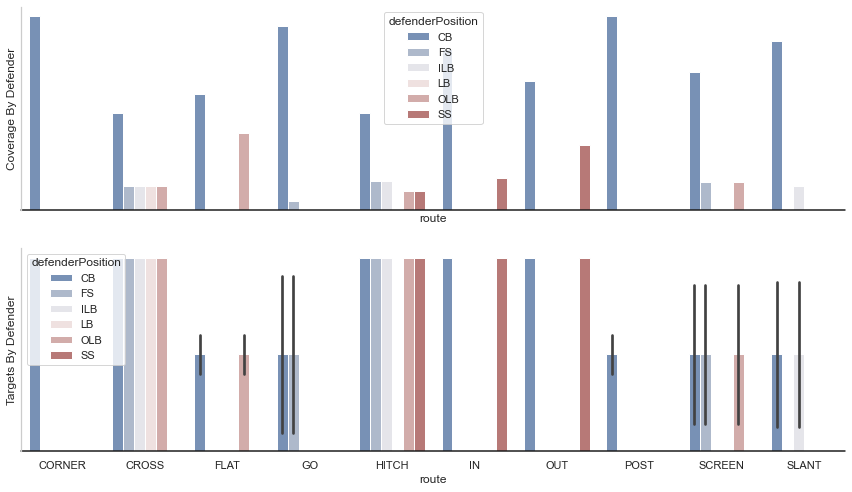

In [128]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Set up the matplotlib figure
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="route", y="DefenderCoveragePercent", data=df4, palette="vlag"
             ,hue = 'defenderPosition', ax = ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Coverage By Defender")

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="route", y="Percent", data=df4, palette="vlag"
             ,hue = 'defenderPosition', ax = ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Targets By Defender")

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

In [73]:
df1 = final.groupby('route').defenderPosition.value_counts(normalize = True ).to_frame()

df1 = df1.rename(columns = {"defenderPosition":"DefenderCoveragePercent"})

df1['DefenderCoveragePercent'] = df1['DefenderCoveragePercent'] * 100
df1['DefenderCoveragePercent'] = df1['DefenderCoveragePercent'].round(decimals=2)
df1

DefenderCoveragePercent
route  defenderPosition                         
CORNER CB                                 100.00
CROSS  CB                                  50.00
       FS                                  12.50
       ILB                                 12.50
       LB                                  12.50
       OLB                                 12.50
FLAT   CB                                  60.00
       OLB                                 40.00
GO     CB                                  95.24
       FS                                   4.76
HITCH  CB                                  50.00
       FS                                  15.00
       ILB                                 15.00
       OLB                                 10.00
       SS                                  10.00
IN     CB                                  83.33
       SS                                  16.67
OUT    CB                                  66.67
       SS                                  33.33
POST   CB                                 100.00
SCREEN CB                                  71.43
       FS                                  14.29
       OLB                                 14.29
SLANT  CB                                  87.50
       ILB                                 12.50

In [760]:
df2 = final.groupby('route').targeted.value_counts(normalize = True ).to_frame()

df2 = df2.rename(columns = {'targeted':'TargetedPercent'})

df2['TargetedPercent'] = df2['TargetedPercent'] * 100
df2['TargetedPercent'] = df2['TargetedPercent'].round(decimals=2)
df2

TargetedPercent
route  targeted                     
CORNER Not Targeted           100.00
CROSS  Not Targeted           100.00
GO     Not Targeted           100.00
HITCH  Not Targeted           100.00
IN     Not Targeted           100.00
OUT    Not Targeted           100.00
POST   Not Targeted            66.67
       Targeted                33.33
SCREEN Not Targeted           100.00
SLANT  Targeted               100.00

In [690]:
df2.TargetedPercent.index

MultiIndex([('CORNER', 'Not Targeted'),
            ('CORNER',     'Targeted'),
            ( 'CROSS', 'Not Targeted'),
            ( 'CROSS',     'Targeted'),
            (  'FLAT', 'Not Targeted'),
            (  'FLAT',     'Targeted'),
            (    'GO', 'Not Targeted'),
            ( 'HITCH', 'Not Targeted'),
            ( 'HITCH',     'Targeted'),
            (    'IN', 'Not Targeted'),
            (   'OUT', 'Not Targeted'),
            (  'POST', 'Not Targeted'),
            ( 'SLANT', 'Not Targeted')],
           names=['route', 'targeted'])

In [765]:
df2.loc[(df2.index.get_level_values('targeted') == "Targeted")]

TargetedPercent
route targeted                 
POST  Targeted            33.33
SLANT Targeted           100.00

In [701]:
#print (df2.iloc[:, df2.columns.get_level_values(0)=='targeted'])


#df.loc[(df.index.get_level_values('A') > 0.5)


df1 = final.groupby('route').defenderPosition.value_counts(normalize = True ).to_frame()
#df2 = final.groupby(['route'])[['defenderDistance']].mean()
df2 = final.groupby('route').targeted.value_counts(normalize = True ).to_frame()
df2 = df2.loc[(df2.index.get_level_values('targeted') == "Targeted")]

df1.join(df2, how='inner')


defenderPosition  targeted
route  defenderPosition targeted                            
CORNER CB               Targeted          0.500000  0.500000
       FS               Targeted          0.500000  0.500000
CROSS  CB               Targeted          0.500000  0.250000
       OLB              Targeted          0.500000  0.250000
FLAT   CB               Targeted          0.333333  0.333333
       LB               Targeted          0.333333  0.333333
       SS               Targeted          0.333333  0.333333
HITCH  MLB              Targeted          0.300000  0.100000
       FS               Targeted          0.200000  0.100000
       LB               Targeted          0.200000  0.100000
       SS               Targeted          0.200000  0.100000
       OLB              Targeted          0.100000  0.100000